In [1]:
!nvidia-smi

Fri Apr 12 00:49:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.12                 Driver Version: 552.12         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P0             31W /  200W |    1006MiB /  12282MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import os
HOME = os.getcwd()


from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.24 🚀 Python-3.8.18 torch-2.1.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
Setup complete ✅ (12 CPUs, 15.7 GB RAM, 541.5/930.7 GB disk)


In [3]:

import supervision as sv
print("supervision", sv.__version__)
from ultralytics import YOLO

model = YOLO('yolov9e.pt')

supervision 0.19.0


100%|██████████| 112M/112M [00:20<00:00, 5.66MB/s] 


In [5]:
from typing import Iterator
video_path = r"C:\Users\fikre\OneDrive\Masaüstü\traffic_analysis2\raw_video.mp4"
generator = sv.get_video_frames_generator(video_path)
iterator = iter(generator)
frame = next(iterator)
import numpy as np
np.bool = np.bool_


0: 736x1280 4 persons, 15 cars, 12 trucks, 205.2ms
Speed: 14.0ms preprocess, 205.2ms inference, 99.0ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


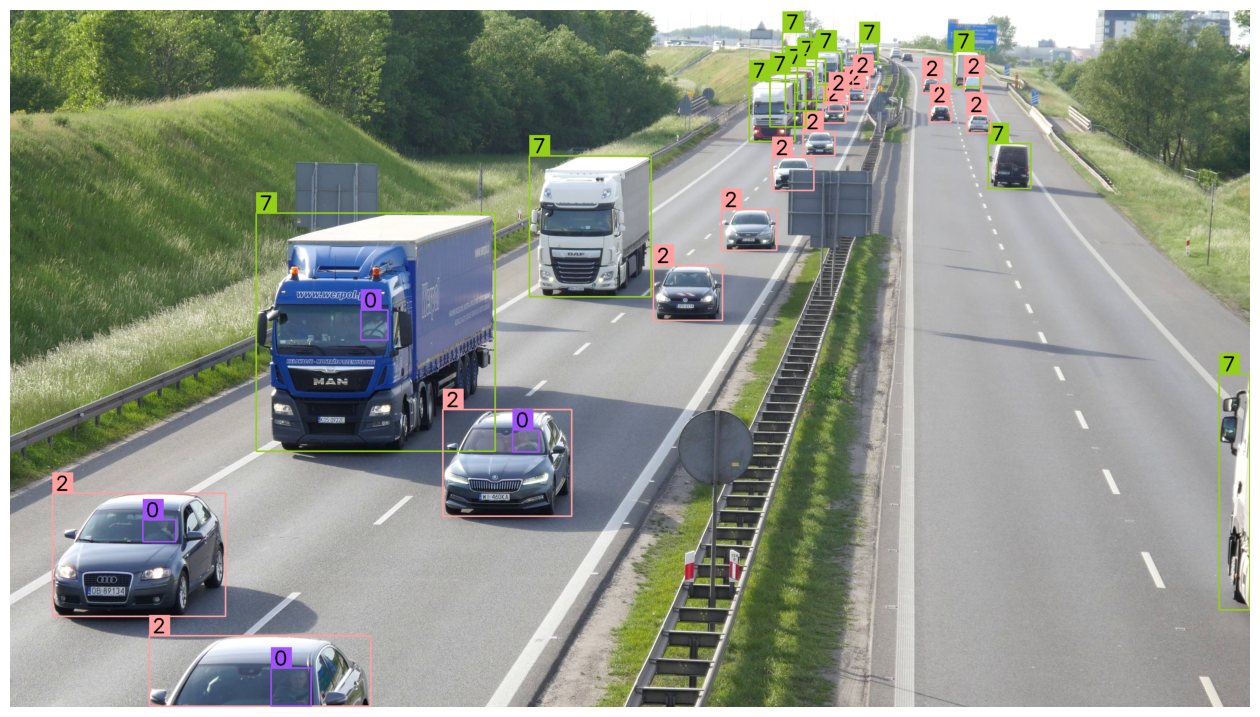

In [6]:
results = model(frame, imgsz = 1280)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator(thickness = 4,
                                text_thickness = 4,
                                text_scale = 2)

frame = box_annotator.annotate(scene = frame,
                               detections = detections)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [7]:
sv.VideoInfo.from_video_path(video_path)

VideoInfo(width=3840, height=2160, fps=24, total_frames=307)


0: 736x1280 3 persons, 14 cars, 6 trucks, 46.1ms
Speed: 5.5ms preprocess, 46.1ms inference, 9.0ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


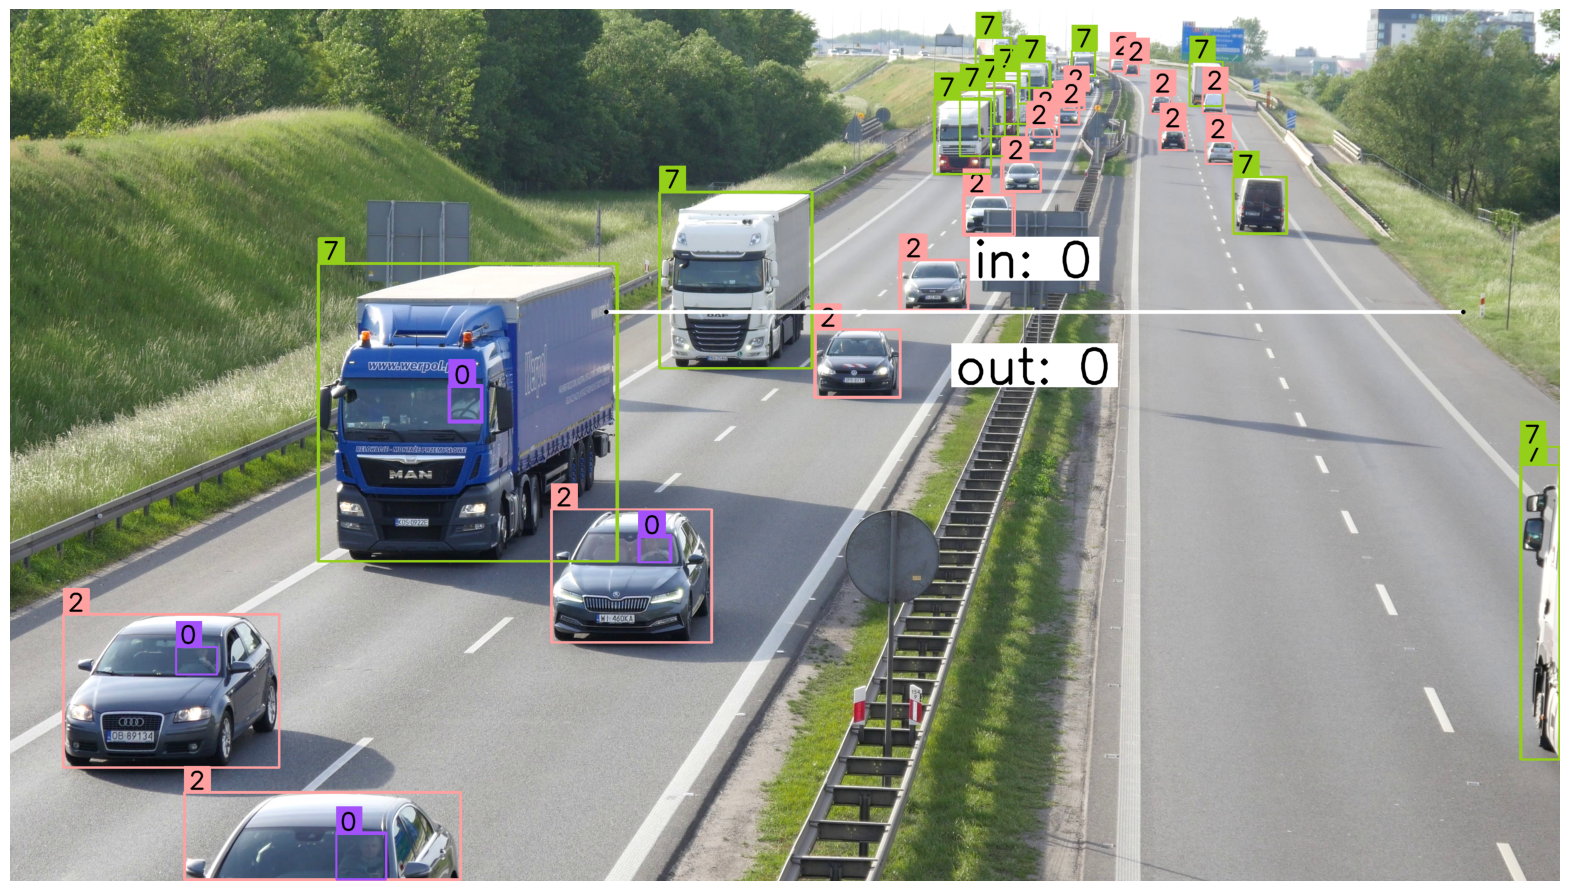

In [8]:
LINE_START = sv.Point(1477, 750)
LINE_END = sv.Point(3600, 750)

line_counter = sv.LineZone(start=LINE_START, end=LINE_END)
line_annotator = sv.LineZoneAnnotator(thickness=8, text_thickness=8, text_scale=4)

results = model(frame, imgsz = 1280)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator(thickness = 4,
                                text_thickness = 4,
                                text_scale = 2)

frame = box_annotator.annotate(scene = frame,
                               detections = detections)
line_annotator.annotate(frame=frame, line_counter=line_counter)
%matplotlib inline
sv.plot_image(frame, (20, 16))

In [10]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

LINE_START = sv.Point(1477, 750)
LINE_END = sv.Point(3600, 750)

line_counter = sv.LineZone(start=LINE_START, end=LINE_END)
line_annotator = sv.LineZoneAnnotator(thickness=8, text_thickness=8, text_scale=4)


tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()
heat_map_annotator = sv.HeatMapAnnotator()
corner_annotator = sv.BoxCornerAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    selected_classes = [2, 5, 7]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)
    detections = detections[np.isin(detections.class_id, selected_classes)]

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]
    line_counter.trigger(detections=detections)
    line_annotator.annotate(frame=frame, line_counter=line_counter)
    annotated_frame = corner_annotator.annotate(
        frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)
    annotated_frame = heat_map_annotator.annotate(
        annotated_frame, detections=detections
    )
    annotated_frame = corner_annotator.annotate(
        annotated_frame, detections=detections
    )
    return trace_annotator.annotate(
        annotated_frame, detections=detections)

    
sv.process_video(
    source_path=video_path,
    target_path="result_traffic.mp4",
    callback=callback
)


0: 384x640 13 cars, 8 trucks, 181.4ms
Speed: 2.0ms preprocess, 181.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 8 trucks, 87.7ms
Speed: 2.0ms preprocess, 87.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 8 trucks, 87.6ms
Speed: 1.0ms preprocess, 87.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 8 trucks, 76.8ms
Speed: 2.0ms preprocess, 76.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 8 trucks, 66.8ms
Speed: 1.0ms preprocess, 66.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13 cars, 9 trucks, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12 cars, 10 trucks, 67.6ms
Speed: 2.0ms preprocess, 67.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12 cars, 9